In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r drive/MyDrive/dataset.zip . 

In [ ]:
!unzip -qq dataset.zip

In [ ]:
!pip install -q segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.7 MB/s eta 0:00:00


In [ ]:
# imports & constants needed

import pandas as pd
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
import cv2
import torch
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
from torchvision.transforms import ToTensor
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import copy
from collections import defaultdict
from torch.cuda import amp
from tqdm import tqdm
tqdm.pandas()
import segmentation_models_pytorch as smp
import torch.nn as nn
import gc

# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SIZE = (224, 224)
BATCH_SIZE = 24

In [ ]:
# load from file training, validation and test dataframes
df_train = pd.read_csv('uw-madison-gi-tract-image-segmentation/datasets/train.csv', sep='\t')
df_test = pd.read_csv('uw-madison-gi-tract-image-segmentation/datasets/test.csv', sep='\t')
df_val = pd.read_csv('uw-madison-gi-tract-image-segmentation/datasets/validation.csv', sep='\t')

df_train = df_train.fillna('')
df_test = df_test.fillna('')
df_val = df_val.fillna('')
df_train.head()

,id,large_bowel,small_bowel,stomach,path,width,height,organ
0,case124_day20_slice_0081,28568 5 28833 7 29098 9 29363 10 29629 10 2989...,33943 7 34168 3 34208 11 34433 4 34473 13 3469...,28088 11 28353 14 28617 17 28882 19 29148 20 2...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,stomach_small_bowel_large_bowel
1,case9_day0_slice_0086,22451 1 22804 10 22827 10 23163 12 23185 13 23...,27877 5 28236 7 28595 11 28955 11 29315 11 296...,,uw-madison-gi-tract-image-segmentation/train/c...,360,310,small_bowel_large_bowel
2,case9_day22_slice_0077,20285 1 20626 10 20644 4 20985 12 21003 5 2103...,49066 3 49425 6 49784 9 50144 10 50504 11 5086...,,uw-madison-gi-tract-image-segmentation/train/c...,360,310,small_bowel_large_bowel
3,case115_day0_slice_0098,11569 8 11831 15 11853 5 12094 21 12118 13 123...,17477 2 17720 2 17728 9 17741 6 17977 2 17983 ...,,uw-madison-gi-tract-image-segmentation/train/c...,266,266,small_bowel_large_bowel
4,case54_day39_slice_0069,26030 4 26294 8 26560 9 26825 10 27091 10 2735...,,17719 14 17983 18 18249 20 18514 23 18779 26 1...,uw-madison-gi-tract-image-segmentation/train/c...,266,266,stomach_large_bowel


In [ ]:
# set seed
seed = 13
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
# utility function to get a mask given a RLE encoding and a shape
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts = []
    lengths = []
    ends = []

    for i in range(0, len(s), 2):
      start_pixel = int(s[i])-1;
      starts.append(start_pixel)
      lengths.append(int(s[i+1]))
      ends.append(start_pixel + int(s[i+1]))

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape)  


# utility function to encode a mask into RLE representation
def rle_encode(img):
    pixels = img.flatten()

    starting_point = 0;
    encoding = ''
    for i in range(0, len(pixels)):
      if (i == 0 and pixels[i] == 1) or (pixels[i-1] == 0 and pixels[i] == 1):
        starting_point = i;
        encoding += ' ' + str(starting_point + 1);

      if (pixels[i-1] == 1 and pixels[i] == 0) or (i == len(pixels) - 1 and pixels[i] == 1):
        encoding += ' ' + str(i - starting_point)

    return encoding;

# shows an image and the masks for large bowel, small bowel, stomach, with legend for clarity
def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, df, subset="train", transforms=None):
    self.df = df
    self.subset = subset
    self.transforms = transforms

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    # create a 3-tensor for the masks of the 3 organs
    masks = np.zeros((3, SIZE[0], SIZE[1]), dtype=np.float32)
    img_path=self.df['path'].iloc[index]
    width=self.df['width'].iloc[index]
    height=self.df['height'].iloc[index]
    # get image from disk
    img = self.__load_img(img_path)

    masks_list = []
    for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
      # take the encoded RLE mask of a certain index and organ
      encoded_mask = self.df[j].iloc[index]
      mask = rle_decode(encoded_mask, shape=(height, width, 1))
      mask = cv2.resize(mask, SIZE)
      # append mask to mask list
      masks_list.append(np.array(mask))
        
    # apply augmentations to both images and masks
    transformed = self.transforms(image=np.array(img), masks=masks_list)
    img = transformed["image"]
    masks_list = transformed["masks"]

    # create a 3-tensor for the masks, then transpose for pytorch format
    masks[0, :, :] = masks_list[0]
    masks[1, :, :] = masks_list[1]
    masks[2, :, :] = masks_list[2]
    img = img.transpose(2, 0, 1)

    return torch.tensor(img).to(device), torch.tensor(masks).to(device)

  def __load_img(self, img_path):
    # read gray-scale, 16-bit image with 1 channel (unchanged)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    # min-max normalization with min=0, max=255, and type unsigned 8-bit integer
    norm = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # resize to desired dimension
    img = cv2.resize(norm, SIZE)
    # replicate the image in depth 3 times -> [1 (width), 1 (height), 3 (depth)]
    # to get RGB
    img = np.tile(img[:, :, None], [1, 1, 3])

    return img

In [ ]:
data_transforms = {
    "train": A.Compose([
      # CLAHE is always applied to enhance contrast
      A.CLAHE(clip_limit=2.0, always_apply=True),
      # 3% max shift, 20 degrees max rotation, border is filled with black pixels
      A.ShiftScaleRotate(shift_limit=0.03, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.85), 
      A.OneOf([
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, 
                                                      border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
                A.GridDistortion(num_steps=5, distort_limit=0.1, 
                                                    border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5)
            ], p=0.2),

      # add small amount of gaussian noise, some blur
      A.OneOf([
                A.GaussNoise(var_limit=(0.0001, 0.004), p=0.7),
                A.Blur(blur_limit=3, p=0.3)
            ], p=0.5),      

      # vertical or horizontal flip
      A.Flip(p=0.5)
    ]),
    # CLAHE is always applied to enhance contrast
    "test": A.Compose([A.CLAHE(clip_limit=2.0, always_apply=True)])
}

In [ ]:
# get the possible organ labels in the training dataframe
# (e.g.: stomach, stomach_large_bowel, small_bowel_large_bowel, ...) 
classes = np.unique(df_train['organ'])
# count occurrences for all the classes
class_sample_count = np.array([len(np.where(df_train['organ'] == t)[0]) for t in classes])
# compute class weights, inversely proportional to class occurrence for batch balancing
class_weight = 1. / class_sample_count

weights = []
# assign class weights to each training sample in the training dataframe
for i in range(len(df_train['organ'])):
  label = df_train['organ'].iloc[i]
  idx = np.where(classes == label)[0]
  weights.append(class_weight[idx][0])

# print some weights for weighted random sampler
weights[0:10]

[0.0003856536829926726,
 0.00015867978419549348,
 0.00015867978419549348,
 0.00015867978419549348,
 0.00041425020712510354,
 0.0003856536829926726,
 0.0003856536829926726,
 0.00015867978419549348,
 0.00015867978419549348,
 0.00015867978419549348]

In [ ]:
# load train dataframe as custom dataset, applying 'train' augmentations
train_dataset = CustomDataset(df_train, subset="train", transforms=data_transforms['train'])
# load validation dataframe as custom dataset, applying 'test' augmentations
valid_dataset = CustomDataset(df_val, subset="validation", transforms=data_transforms['test'])
# init weighted random sampler for batch balancing
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), len(df_train))

# load dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=False, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# load dice and binary cross entropy losses
dice_loss = smp.losses.DiceLoss(mode='multilabel')
bce_loss = smp.losses.SoftBCEWithLogitsLoss()

# compound loss
def compound_loss_function(y_pred, groundtruth):
  return 0.4*dice_loss(y_pred, groundtruth) + 0.6*bce_loss(y_pred, groundtruth)

In [ ]:
# project float pixel predictions from [0, 1] to {0, 1}, then compute dice with formula
def dice_coefficient(groundtruth, y_pred, thr=0.5, epsilon=0.001):
    groundtruth = groundtruth.to(torch.float32)

    # round elements of y_pred
    y_pred = (y_pred>thr).to(torch.float32)

    # dimensions (NxCxWxH)
    # N: images' index in a batch
    # C: depth (channel)
    # W: width
    # H: height

    # (groundtruth AND prediction) of each layer of the mask torch tensor 
    # cardinality of the intersection
    intersection = (groundtruth*y_pred).sum(dim=(2,3))
    denominator = groundtruth.sum(dim=(2,3)) + y_pred.sum(dim=(2,3))
    dice = ((2*intersection+epsilon)/(denominator+epsilon)).mean(dim=(1,0))
    return dice


In [ ]:
# when using mixed-precision training it's important to be careful about the range of values 
# that the lower-precision numbers can represent, as very small or very large gradients 
# can lead to numerical instability and loss of precision. 
# The gradient scaler addresses this issue by automatically 
# rescaling the gradients during backpropagation, 
# so that they fall within a safe numerical range.

def train_one_epoch(model, optimizer, scheduler, dataloader, epoch):
    # set training mode
    model.train()
    # gradient scaler
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0

    score_values = []

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    
    for i, (images, masks) in progress_bar:      
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        y_pred = 0
        with amp.autocast(enabled=True):
            # get predicted value, forward pass
            y_pred = model(images)
            # compute the loss
            loss = compound_loss_function(y_pred, masks)
            
        # backpropagation 
        scaler.scale(loss).backward()
        # step optimizer with the scaler
        scaler.step(optimizer)
        scaler.update()
        
        # zero the gradient
        optimizer.zero_grad()
        
        if scheduler != None:
          scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size
        
        # take the current learning rate
        current_learning_rate = optimizer.param_groups[0]['lr']
        progress_bar.set_postfix(train_loss=f'{epoch_loss:0.5f}',
                        lr=f'{current_learning_rate:0.7f}')

        # put prediction in [0,1]
        y_pred = nn.Sigmoid()(y_pred) 
        # from torch tensor to numpy value
        dice = dice_coefficient(masks, y_pred).cpu().detach().numpy()
        score_values.append(dice)

        del images, masks, y_pred, loss

    epoch_mean_dice  = np.mean(score_values, axis=0)
    return epoch_loss, epoch_mean_dice

In [ ]:
# disable autograd as we do not need to backpropagate during validation
@torch.no_grad()
def valid_one_epoch(model, dataloader, epoch):
    # set test mode to disable dropout and prepare batch normalization layers
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    score_values = []
    
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for i, (images, masks) in progress_bar:   
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        # get predicted value, forward pass
        y_pred = model(images)
        # compute the loss
        loss = compound_loss_function(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size
        
        # put prediction in [0,1]
        y_pred = nn.Sigmoid()(y_pred) 
        # from torch tensor to numpy value
        dice = dice_coefficient(masks, y_pred).cpu().detach().numpy()
        
        score_values.append(dice)
        del images, masks, y_pred, loss
        
        progress_bar.set_postfix(valid_loss=f'{epoch_loss:0.4f}')

    # calculate mean dice coefficient values for batches
    epoch_mean_dice = np.mean(score_values, axis=0)   
    return epoch_loss, epoch_mean_dice

In [ ]:
def run_training(model, optimizer, scheduler, num_epochs):
    best_model_parameters = copy.deepcopy(model.state_dict())
    best_dice = -np.inf
    best_epoch = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        print(f'Epoch {epoch} - {num_epochs}', end='')

        train_loss, train_mean_dice = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, epoch=epoch)
        
        validation_loss, validation_mean_dice = valid_one_epoch(model, valid_loader, epoch=epoch)
    
        history['Train Loss'].append(train_loss)
        history['Validation Loss'].append(validation_loss)
        history['Validation Dice'].append(validation_mean_dice)
        
        print(f'Validation Dice: {validation_mean_dice:0.4f}')
        
        # Save the best model during the training
        if validation_mean_dice >= best_dice:
            best_dice = validation_mean_dice
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "best_model.bin"
            torch.save(model.state_dict(), PATH)            
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
# Unet++ model with imagenet weights in the encoder, efficientnetb3 as encoder, 
# taking as input RGB images and predicting 3 classes (large bowel, small bowel, stomach)
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b3",     
    encoder_weights="imagenet",     
    in_channels=3,                 
    classes=3,                
)  

print(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticS

In [ ]:
# freeze encoder, leave decoder and segmentation head unfreezed
for param in model.encoder.parameters():
  param.requires_grad = False

# push to gpu
model.to(device)  

optimizer = optim.RMSprop(model.parameters(), lr=5e-5, momentum=0.9)             
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

In [ ]:
model, history = run_training(model, optimizer, scheduler, 10)

Epoch 1 - 10

Valid : 100%|██████████| 63/63 [00:31<00:00,  2.03it/s, valid_loss=0.1556]


Validation Dice: 0.6566
Epoch 2 - 10

Valid : 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, valid_loss=0.1389]


Validation Dice: 0.6853
Epoch 3 - 10

Valid : 100%|██████████| 63/63 [00:30<00:00,  2.04it/s, valid_loss=0.1139]


Validation Dice: 0.7518
Epoch 4 - 10

Valid : 100%|██████████| 63/63 [00:32<00:00,  1.94it/s, valid_loss=0.1031]


Validation Dice: 0.7739
Epoch 5 - 10

Valid : 100%|██████████| 63/63 [00:31<00:00,  1.98it/s, valid_loss=0.1083]


Validation Dice: 0.7807
Epoch 6 - 10

Valid : 100%|██████████| 63/63 [00:30<00:00,  2.04it/s, valid_loss=0.0950]


Validation Dice: 0.7961
Epoch 7 - 10

Valid : 100%|██████████| 63/63 [00:30<00:00,  2.03it/s, valid_loss=0.0952]


Validation Dice: 0.7874
Epoch 8 - 10

Valid : 100%|██████████| 63/63 [00:31<00:00,  2.02it/s, valid_loss=0.0878]


Validation Dice: 0.8158
Epoch 9 - 10

Valid : 100%|██████████| 63/63 [00:31<00:00,  2.00it/s, valid_loss=0.0897]


Validation Dice: 0.8077
Epoch 10 - 10

Valid : 100%|██████████| 63/63 [00:31<00:00,  2.01it/s, valid_loss=0.0971]

Validation Dice: 0.7901


In [ ]:
import pickle
file_name = 'history-decoder-training.dump'
with open(file_name, 'wb') as file:
    pickle.dump(history, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "history-decoder-training.dump"


In [ ]:
!mv history-decoder-training.dump drive/MyDrive/

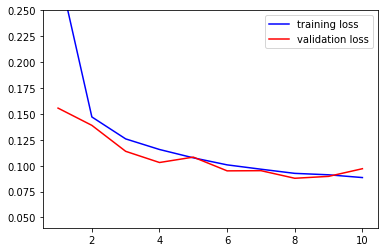

In [ ]:
x = np.linspace(1, 10, 10)

plt.plot(x, history["Train Loss"], "-b", label="training loss")
plt.plot(x, history["Validation Loss"], "-r", label="validation loss")
plt.legend(loc="upper right")
plt.ylim(0.04, 0.25)
plt.show()

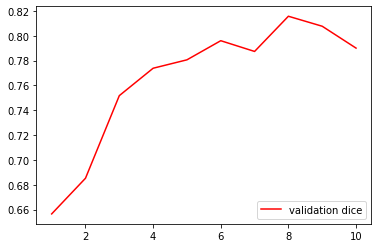

In [ ]:
x = np.linspace(1, 10, 10)

plt.plot(x, history["Validation Dice"], "-r", label="validation dice")
plt.legend(loc="lower right")
plt.show()

In [ ]:
PATH = "best_decoder.bin"
torch.save(model.state_dict(), PATH)    

In [ ]:
!mv best_decoder.bin drive/MyDrive/

In [ ]:
model.load_state_dict(torch.load("drive/MyDrive/best_decoder.bin", map_location=device))

# unfreeze last encoder layer
for param in model.encoder.parameters():
  param.requires_grad = False
model.encoder._blocks[-1:].requires_grad_(True)
model.encoder._conv_head.requires_grad_(True)
model = model.to(device)


optimizer = optim.RMSprop(model.parameters(), lr=1e-6, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=560, gamma=0.9)
model, history = run_training(model, optimizer, scheduler, 5)

Epoch 1 - 5

Valid : 100%|██████████| 63/63 [00:35<00:00,  1.78it/s, valid_loss=0.0854]


Validation Dice: 0.8150
Epoch 2 - 5

Valid : 100%|██████████| 63/63 [00:33<00:00,  1.86it/s, valid_loss=0.0848]


Validation Dice: 0.8185
Epoch 3 - 5

Valid : 100%|██████████| 63/63 [00:33<00:00,  1.85it/s, valid_loss=0.0845]


Validation Dice: 0.8195
Epoch 4 - 5

Valid : 100%|██████████| 63/63 [00:33<00:00,  1.88it/s, valid_loss=0.0841]


Validation Dice: 0.8221
Epoch 5 - 5

Valid : 100%|██████████| 63/63 [00:34<00:00,  1.81it/s, valid_loss=0.0834]


Validation Dice: 0.8247


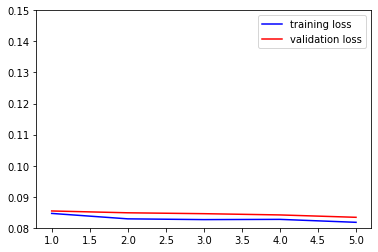

In [ ]:
x = np.linspace(1, 5, 5)

plt.plot(x, history["Train Loss"], "-b", label="training loss")
plt.plot(x, history["Validation Loss"], "-r", label="validation loss")
plt.legend(loc="upper right")
plt.ylim(0.08, 0.15)
plt.show()

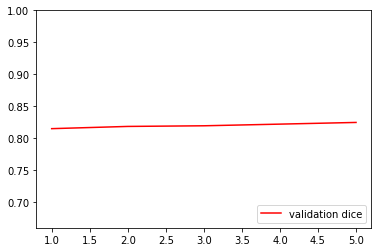

In [ ]:
x = np.linspace(1, 5, 5)
plt.ylim(0.66, 1)
plt.plot(x, history["Validation Dice"], "-r", label="validation dice")
plt.legend(loc="lower right")
plt.show()

In [ ]:
PATH = "best_model_FineTuned.bin"
torch.save(model.state_dict(), PATH)  

In [ ]:
!mv best_model_FineTuned.bin drive/MyDrive/

In [ ]:
model.load_state_dict(torch.load("drive/MyDrive/best_model_FineTuned.bin", map_location=device))


<All keys matched successfully>

In [ ]:
# test the best model on test set
test_dataset = CustomDataset(df_test, subset="test", transforms=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_one_epoch(model, test_loader, 1)

Valid : 100%|██████████| 70/70 [00:40<00:00,  1.71it/s, valid_loss=0.0833]


(0.0833257069073577, 0.824812)

In [ ]:
# take some predictions from the test set
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

imgs, msks =  next(iter(test_loader))
imgs = imgs.to(device, dtype=torch.float)
msks = msks.cpu().detach()
preds = []
with torch.no_grad():
    pred = model(imgs)
    pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    

imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

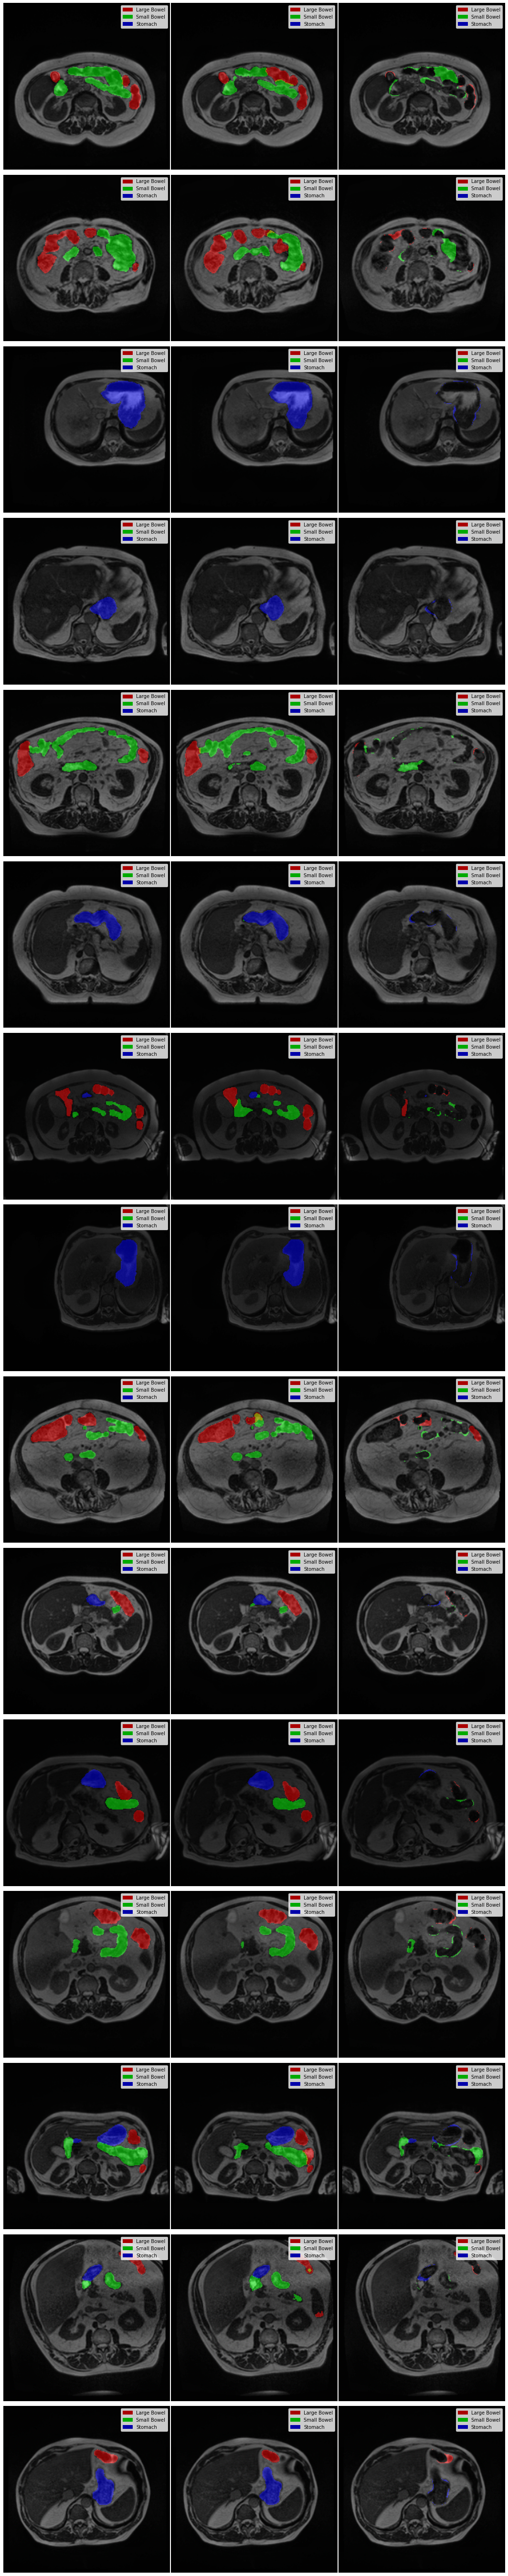

In [ ]:
# compare the predictions with the real masks
def plot_batch_comparison(imgs, masks, pred_masks, size=3):
    plt.figure(figsize=(15, 5*size))
    for idx in range(size):
      # plot image + real masks (on the left)
      plt.subplot(size, 3, 1 + idx*3)
      img = imgs[idx].permute((1, 2, 0)).numpy().astype(np.uint8)
      msk = masks[idx].permute((1, 2, 0)).numpy()
      show_img(img, msk)

      # plot image + predicted masks (on the middle)
      plt.subplot(size, 3, 2 + idx*3)
      msk = pred_masks[idx].permute((1, 2, 0)).numpy()
      show_img(img, msk)

      # plot image + difference of predictions (on the right)
      sub = (masks-pred_masks)[idx].permute((1, 2, 0)).numpy()
      plt.subplot(size, 3, 3 + idx*3)
      show_img(img, sub)

    plt.tight_layout()
    plt.show()

plot_batch_comparison(imgs, msks, preds, size=15)